# Stats 404 Final Project
## Flower Classification with Transfer Learning

In this code, I use the flower image dataset from Kaggle here: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition. The data was collected from data flicr, google images, and yandex images. It contains 5 types of flowers: daisies, dandelions, roses, sunflowers, and tulips. Most of the images have resolution less than or equal to about 320x240 pixels.

I was able to train, tune/validate, and test a neural network model that leverages the structure and pretrained weights from the well-known ResNet50 model. I froze the ResNet weights and trained an additional hidden layer before making the final classification. This approach is generally referred to as "transfer learning".

The overall classification accuracy of this model was about 91%, with each class of flower reporting individual accuracies ranging from approximately 87% to 94%.

This code was used with Googles Compute Engine backend (GPU), containing roughly 40GB of vRAM. Google Drive was mounted to read/write files via drive.

## Load Libraries

In [ ]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.nn.modules.dropout import Dropout
import numpy as np
import random
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import torchvision.models as models
import albumentations as T
import cv2 
from collections import Counter
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


Here I output information about the GPU used for training.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 12 20:40:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount Google Drive, download compressed data locally, then unzip the data.

Although there was no traditional "missing data", one data processing consideration I had was to quickly read in the images while training. I found that it was quickest to simply transfer a zip file with the flower dataset from my google drive and then unzip the flower data to a specified folder on the current runtime. This was found to be substantially faster than constantly reading data from my google drive throughout training and testing.

In [ ]:
%%capture
load_and_unzip = True

if load_and_unzip:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')

    # copy image data to runtime
    %cp -av drive/MyDrive/TMP/dataset/Archive.zip .
    !mkdir dataset

    # unzip the image data
    !unzip Archive.zip -d dataset/
    !rm -r dataset/__MACOSX

## Set device (GPU or CPU)

Set device as CPU, or GPU if available.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
  
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 1


## Load Data

In the code block below, I implemented a few data preprocessing transformations used on each image in the dataset. It first resizes all images to a fixed 224x224 pixels (to be used in our model). Then, each with probability $p=0.5$, it randomly flips the image horizontally and vertically. This attempts to provide a "new" look at potentially already seen data while training. Lastly, I convert the image to a pytorch tensor, and normalize the values using the mean and standard deviation recommended by pytorch when using the ResNet50 model with pretrained weights.

In [ ]:
# create pre-processing transforms for data
tr_transf = transforms.Compose(
    [ 
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


# read in the image data as an pytorch dataset instance
data = ImageFolder('dataset/', transform=tr_transf)

# display list of flower types within data
data.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Displaying a few different flowers from the dataset

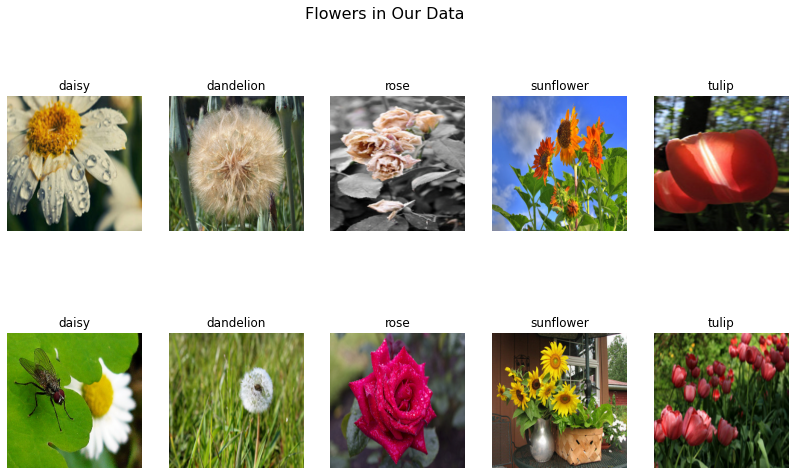

In [ ]:
def imshow(img: torch.FloatTensor):
    """
      Un-normalize the image, then plot the image in the appropriate 
      channel order.
      
      :param img: the image to be plotted
    """
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = 255*(img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))


# get the paths to all flower images in our data
flower_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
flower_dict = dict()

for i in flower_names:
    xx = os.listdir(os.path.join('dataset/', i))
    flower_dict[i] = xx

# transform for presentation purposes only
pres_transf = T.Compose(
    [T.Resize(224, 224),  
     T.Normalize()
    ])

# random choice of index data for each flower (so it changes every time)
x = random.randint(0,50)

# creae a 2x5 grid of flower images with 2 from each category 
plt.figure(figsize=(14,8))
for i, flower in enumerate(flower_dict):
    plt.suptitle("Flowers in Our Data", fontsize = 16)
    plt.subplot(2, 5, i + 1)

    # full path to chosen image
    img_path = os.path.join('dataset/', flower, flower_dict[flower][x])

    # read image and convert to RGB channel order
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # apply transforms
    img = pres_transf(image =img)['image'].astype(np.float32)
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img).float()

    # display image
    imshow(img)
    plt.title(flower)
    plt.axis('off')

    plt.subplot(2, 5, i + 1 + 5)

    # full path to chosen image
    img_path = os.path.join('dataset/', flower, flower_dict[flower][x+1])

    # read image and convert to RGB channel order
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # apply transforms
    img = pres_transf(image=img)['image'].astype(np.float32)
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img).float()

    # display image
    imshow(img)
    plt.title(flower)
    plt.axis('off')

plt.show()




## Train-Test Split

I set a random seed, then I randomly split the data into a training, validation, and testing datasets. I use 80% for the training set, 5% for the validation set, and 15% for the testing set. 

I then output the number of images in each flower category for each set to make sure there is a large enough number of each individual flower type for training and testing.

The batch size was set to 64 images, and the dataloaders were instantiated for each associated set of data.

In [ ]:
# set seed
torch.manual_seed(42)

# training, validation, and testing split of data
train, val, test = random_split(data, [0.8, 0.05, 0.15], generator=torch.Generator().manual_seed(42))

print(f"Training set size: {len(train)}")
train_classes = [label for _, label in train]
print("Training set value-counts:", dict(Counter(train_classes)))

print(f"\nValidation set size: {len(val)}")
val_classes = [label for _, label in val]
print("Validation set value-counts:", dict(Counter(val_classes)))

print(f"\nTesting set size: {len(test)}")
test_classes = [label for _, label in test]
print("Testing set value-counts:", dict(Counter(test_classes)))

batchsize = 64  # set batch size
trainloader = DataLoader(train, batch_size = batchsize, shuffle=True)
valloader = DataLoader(val, batch_size = batchsize)
testloader = DataLoader(test, batch_size = batchsize)

Training set size: 3454
Training set value-counts: {2: 631, 1: 855, 0: 597, 3: 584, 4: 787}

Validation set size: 216
Validation set value-counts: {4: 57, 2: 38, 3: 40, 1: 41, 0: 40}

Testing set size: 647
Testing set value-counts: {3: 109, 4: 140, 2: 115, 0: 127, 1: 156}


## Designing the Neural Network for Flower Classification

As mentioned above, I leveraged the architecture of the popular residual network model "ResNet50", and used its pretrained weights from the IMAGENET (Version 2) to extract the features of the flower images. 

After freezing the original ResNet50 weights (so they don't change while training), I added another linear layer between the output from the ResNet50 model and the classifications. To help speed up the training process, I used batch normalization. Additionally, I used a dropout (with $p = 0.2$) to help prevent overfitting during training.


I use the standard Cross Entropy Loss function with an Adam optimizer. The learning rate was set to $2\cdot10^{-3}$ after some tuning on the validation results. I also set up a scheduler to decrease the learning rate after every 5 steps (I implemented a step after each epoch).

In [ ]:
class FlowerResNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.feature_extr = models.resnet50(weights="IMAGENET1K_V2") # 1000 neuron output

        # freezing the resnet50 parameters
        for param in self.feature_extr.parameters(): 
            param.requires_grad = False

        # adding another hidden layer before classificaion
        self.classify = nn.Sequential(nn.Linear(1000, 512),
                                      nn.BatchNorm1d(512),
                                      nn.Dropout(p = 0.2),
                                      nn.ReLU(),
                                      nn.Linear(512, 5))
        
    def forward(self, xx: torch.FloatTensor):

        xx = self.feature_extr(xx)
        out = self.classify(xx)
        return out
    
net = FlowerResNet()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 2e-3)
lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Train and Validate the Neural Network

The training was done in the code block below. I used an excessive 20 epochs here to see what happens to the validation set over time. At the beginnning of each epoch, I check the CUDA memory. And at the end of each epoch, I obtain the validation results (loss and accuracy). This helped me find an optimal number of epochs.

In [ ]:
cache = []

for epoch in range(20):

    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    net.train()
    train_losses = []

    for batch in trainloader:

        # extract the data, then send to current device
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward step
        out = net.forward(images)       

        # store loss          
        loss = criterion(out, labels) 
        train_losses.append(loss)

        # learn (backward step)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # step forward for the learning rate scheduler
    lr_sched.step()
    
    # obtain validation results
    with torch.no_grad():
        net.eval()

        val_losses = []
        running_match = 0.0
        running_total = 0
        for i, batch in enumerate(valloader, 0):

            # extract the data, then send to current device
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)

            # forward step to obtain validation loss and predictions
            out = net.forward(images)                    
            loss = F.cross_entropy(out, labels)  
            _, preds = torch.max(out, dim=1)

            # store validation results from this epoch
            val_losses.append(loss)
            running_match += torch.tensor(torch.sum(preds == labels).item())
            running_total += len(preds)


        train_loss = torch.stack(train_losses).mean().item()
        val_loss = torch.stack(val_losses).mean().item()
        val_acc = running_match / running_total

        print(f"Epoch [{epoch+1}]: Training Loss = {train_loss:.3f} | Validation Loss = {val_loss:.3f} | Validation Score = {val_acc:.3f} \n")
        
    # store the validation results from each epoch
    cache.append((train_loss, val_loss, val_acc))


CUDA Memory Allocated: 105118208
Epoch [1]: Training Loss = 0.497 | Validation Loss = 0.358 | Validation Score = 0.870 

CUDA Memory Allocated: 856358400
Epoch [2]: Training Loss = 0.265 | Validation Loss = 0.308 | Validation Score = 0.903 

CUDA Memory Allocated: 856360448
Epoch [3]: Training Loss = 0.224 | Validation Loss = 0.339 | Validation Score = 0.889 

CUDA Memory Allocated: 856360448
Epoch [4]: Training Loss = 0.187 | Validation Loss = 0.354 | Validation Score = 0.889 

CUDA Memory Allocated: 856360448
Epoch [5]: Training Loss = 0.150 | Validation Loss = 0.371 | Validation Score = 0.861 

CUDA Memory Allocated: 856360448
Epoch [6]: Training Loss = 0.114 | Validation Loss = 0.311 | Validation Score = 0.903 

CUDA Memory Allocated: 856360448
Epoch [7]: Training Loss = 0.083 | Validation Loss = 0.299 | Validation Score = 0.898 

CUDA Memory Allocated: 856360448
Epoch [8]: Training Loss = 0.074 | Validation Loss = 0.321 | Validation Score = 0.917 

CUDA Memory Allocated: 856360448

## Plot the Training and Validation Data

I first extract the training and validation history, and then I plot the training loss and validation loss over each epoch. 

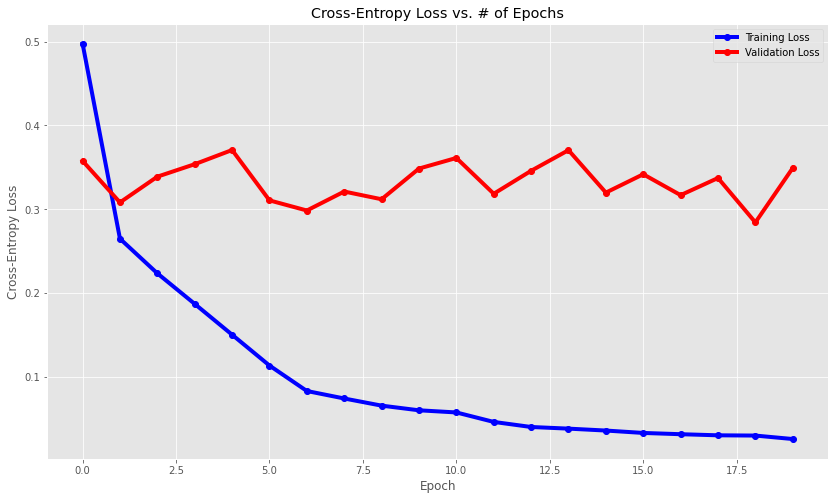

In [ ]:
plt.style.use('ggplot')

# extract training and validation history from cache
train_loss_ot = [i[0] for i in cache]
val_loss_ot = [i[1] for i in cache]
val_acc_ot = [i[2] for i in cache] 

# plot the training and validation loss over the epochs
plt.figure(figsize=(14,8))
plt.plot(train_loss_ot,  '-o', color = 'blue', label = "Training Loss", linewidth=4)
plt.plot(val_loss_ot, '-o', color = 'red', label = "Validation Loss",  linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss vs. # of Epochs')
plt.legend()


We can see that the training loss decreases over training time, while the validaiton loss remains about the same over time.

Now I plot the validation accuracy at each epoch.

Text(0.5, 1.0, 'Valdiation Accuracy vs # of Epochs')

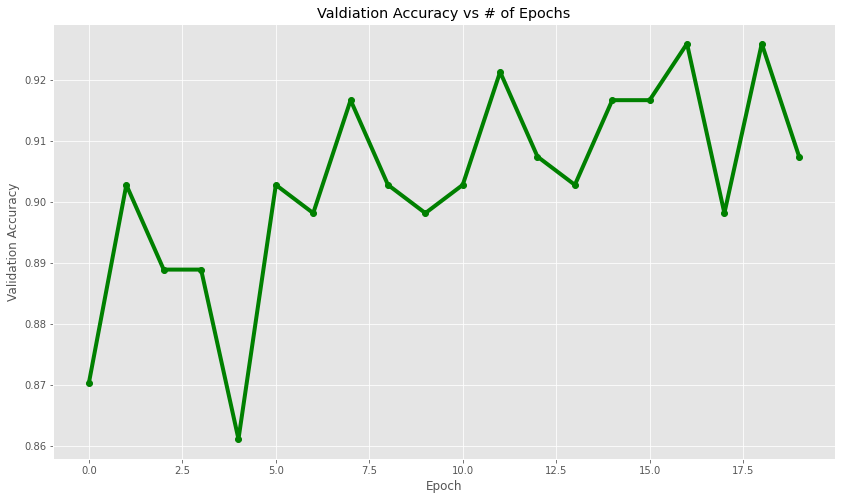

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(val_acc_ot, '-o', color = 'green', linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Valdiation Accuracy vs # of Epochs')

We can see that after about 5 epochs, the validation accuracy jumps above 90%, and then begins to oscillate around 91% for the remainder of training.

## Testing Results



We re-train the network with the training data using 17 epochs as the validation data suggests. The loss function, optimizer, and learning rate settings were all set up the same as before.

In [ ]:
# re-instantiate the network
net = FlowerResNet()
net.to(device)

# setup our loss function, optimizer, and learning rate scheduler as before
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 2e-3)
lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


for epoch in range(17):

    net.train()
    train_losses = []

    for batch in trainloader:

        # extract training data, send to device
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward step
        out = net.forward(images)       

        # store loss          
        loss = criterion(out, labels) 
        train_losses.append(loss)

        # learn (backward step)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate scheduler step
    lr_sched.step()
    print(f"Epoch [{epoch+1}]: Complete!")
    

Epoch [1]: Complete!
Epoch [2]: Complete!
Epoch [3]: Complete!
Epoch [4]: Complete!
Epoch [5]: Complete!
Epoch [6]: Complete!
Epoch [7]: Complete!
Epoch [8]: Complete!
Epoch [9]: Complete!
Epoch [10]: Complete!
Epoch [11]: Complete!
Epoch [12]: Complete!
Epoch [13]: Complete!
Epoch [14]: Complete!
Epoch [15]: Complete!
Epoch [16]: Complete!
Epoch [17]: Complete!


Now we obtain the overall accuracy for our test set.

In [ ]:
running_match = 0.0
running_total = 0.0

with torch.no_grad():
    net.eval()

    val_losses = []
    running_match = 0.0
    running_total = 0
    for i, batch in enumerate(testloader, 0):

        # get the testing data, send to device
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        # run through network to get predictions
        out = net.forward(images)                    
        _, preds = torch.max(out, dim=1)

        # update number matched and total for final accuracy
        running_match += torch.tensor(torch.sum(preds == labels).item())
        running_total += len(preds)

overall_acc = 100 * running_match // running_total
print(f'Overall testing accuracy for the Flower ResNet: {overall_acc}%')

Overall testing accuracy for the Flower ResNet: 91.0%


We can see above that the overall testing accuracy is 91%! We now obtain the accurracies for each flower type.

In [ ]:
correct_per_flower = [0.0 for flower in flower_names]
total_per_flower = [0.0 for flower in flower_names]

with torch.no_grad():
    net.eval()

    val_losses = []
    running_match = 0.0
    running_total = 0
    for i, batch in enumerate(testloader, 0):

        # get the testing data, send to device
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        # run through network to get predictions
        out = net.forward(images)                    
        _, preds = torch.max(out, dim=1)

        # update the number matching and the total for each flower type
        for i in range(len(preds)):
            label = labels[i]
            pred = preds[i]

            if (label == pred):
                correct_per_flower[label] += 1
                
            total_per_flower[label] += 1


# save and print accuracy for each class
class_acc = dict()
for i in range(len(correct_per_flower)):
    acc = 100 * correct_per_flower[i] / total_per_flower[i]
    class_acc[flower_names[i]] = acc
    print(f'Accuracy in {flower_names[i]} flowers is {acc:.2f}%')

Accuracy in daisy flowers is 92.91%
Accuracy in dandelion flowers is 94.23%
Accuracy in rose flowers is 87.83%
Accuracy in sunflower flowers is 90.83%
Accuracy in tulip flowers is 92.14%


We can see that the accuracy for each flower type is very high (over 87%), with the highest at 94.23%! The network seems to do the best job classifying dandelions and the worst job classifying roses. We plot the accuracies for each flower below.

Text(0.5, 1.0, 'Test Accuracy by Flower Type (Overall Accuracy = 91.0 %)')

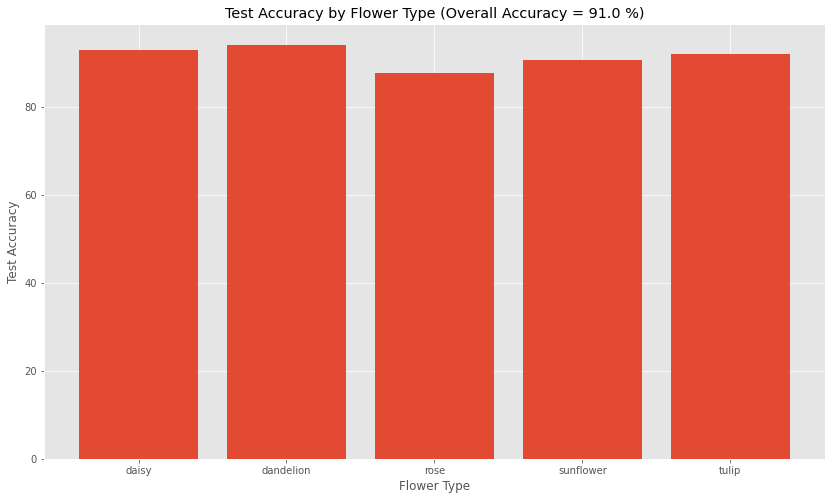

In [ ]:
plt.figure(figsize=(14,8))
plt.bar(class_acc.keys(), class_acc.values())
plt.xlabel('Flower Type')
plt.ylabel('Test Accuracy')
plt.title(f'Test Accuracy by Flower Type (Overall Accuracy = {overall_acc} %)')

# Brief Discussion Of Results

Training the model with the flower images from the training set and tuning the hyperparamters with the validaiton set proved to be successful. The network's overall test accuracy was at approximately 91%! This is incredibly high considering the fact that the expected accuracy from randomly guessing one of the five flower types would be around 20%. Additionally, we found that each flower type had an individual accuracy between about 87% and 94%. The network seems to do the best job classifying dandelions and the worst job classifying roses. However, the network did not demonstrate poor classification ability for any of the flower types. The testing results indicate that the classification ability of this network is very strong.

I should note that before using this transfer learning model, I first tried using a standard CNN network with manually defined convolutional and linear layers. This model took much longer to train since it began with random weights, and plateaued around 70% overall testing accuracy. 